In [95]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.applications import ResNet50V2
from keras.applications import VGG16
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model
import onnx
import tf2onnx
import onnxruntime as ort

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

**Data Partition**

In [17]:
IMG_PATH = '../brain_tumor_dataset/'
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        print(IMG_NUM)
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            print(img)


98
../brain_tumor_dataset/no/N1.JPG
../brain_tumor_dataset/no/N10.jpg
../brain_tumor_dataset/no/N11.jpg
../brain_tumor_dataset/no/N12.jpg
../brain_tumor_dataset/no/N13.jpg
../brain_tumor_dataset/no/N14.jpg
../brain_tumor_dataset/no/N15.jpg
../brain_tumor_dataset/no/N16.jpg
../brain_tumor_dataset/no/N17.jpg
../brain_tumor_dataset/no/N18.jpg
../brain_tumor_dataset/no/N19.JPG
../brain_tumor_dataset/no/N2.JPG
../brain_tumor_dataset/no/N20.JPG
../brain_tumor_dataset/no/N21.jpg
../brain_tumor_dataset/no/N22.JPG
../brain_tumor_dataset/no/N23.jpg
../brain_tumor_dataset/no/N24.jpg
../brain_tumor_dataset/no/N25.jpg
../brain_tumor_dataset/no/N26.JPG
../brain_tumor_dataset/no/N27.jpeg
../brain_tumor_dataset/no/N28.jpg
../brain_tumor_dataset/no/N29.jpg
../brain_tumor_dataset/no/N3.jpg
../brain_tumor_dataset/no/N30.jpeg
../brain_tumor_dataset/no/N31.jpg
../brain_tumor_dataset/no/N32.jpg
../brain_tumor_dataset/no/N33.jpg
../brain_tumor_dataset/no/N34.jpg
../brain_tumor_dataset/no/N35.jpg
../brain_tum

In [19]:
IMG_PATH = '../brain_tumor_dataset/'

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n< (0.2*IMG_NUM):
                shutil.copy(img, '../TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < (0.7*IMG_NUM):
                shutil.copy(img, '../TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, '../VAL/' + CLASS.upper() + '/' + FILE_NAME)

**Data Preprocessing**

In [23]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=16

dataset_dir = '../TRAIN/'
test_dir  = '../TEST/'

def image_gen(height, width, batch_size=16):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.2,
    )

    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="training",
        color_mode="rgb",
        class_mode='binary',
        shuffle=True,
        target_size=(height, width),
    )
    val_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="validation",
        color_mode="rgb",
        class_mode='binary',
        shuffle=True,
        target_size=(height, width),
    )
    
    test_gen = ImageDataGenerator(
        rescale=1./255.
    )
    test_ds = test_gen.flow_from_directory(
        test_dir,
        batch_size=batch_size,
        shuffle=True,
        color_mode="rgb",
        class_mode="binary",
        target_size=(height, width),
    )

    return train_ds, val_ds, test_ds

def augmented_data(height, width):
    datagen = ImageDataGenerator(
        rescale= 1./255.,
        width_shift_range= 0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
    )
    
    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        shuffle=True,
        color_mode="rgb",
        class_mode="binary",
        target_size=(height, width),
    )
    
    return train_ds

train_ds, val_ds, test_ds = image_gen(height, width)

total_images = np.concatenate([train_ds.labels, val_ds.labels, test_ds.labels])
# Print the count of images in each class
print({"No brain tumor cases": len(np.where(total_images == 0)[0]),
       "Brain tumor cases": len(np.where(total_images == 1)[0])})

Found 103 images belonging to 2 classes.


Found 24 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
{'No brain tumor cases': 69, 'Brain tumor cases': 109}


**Data Samples**

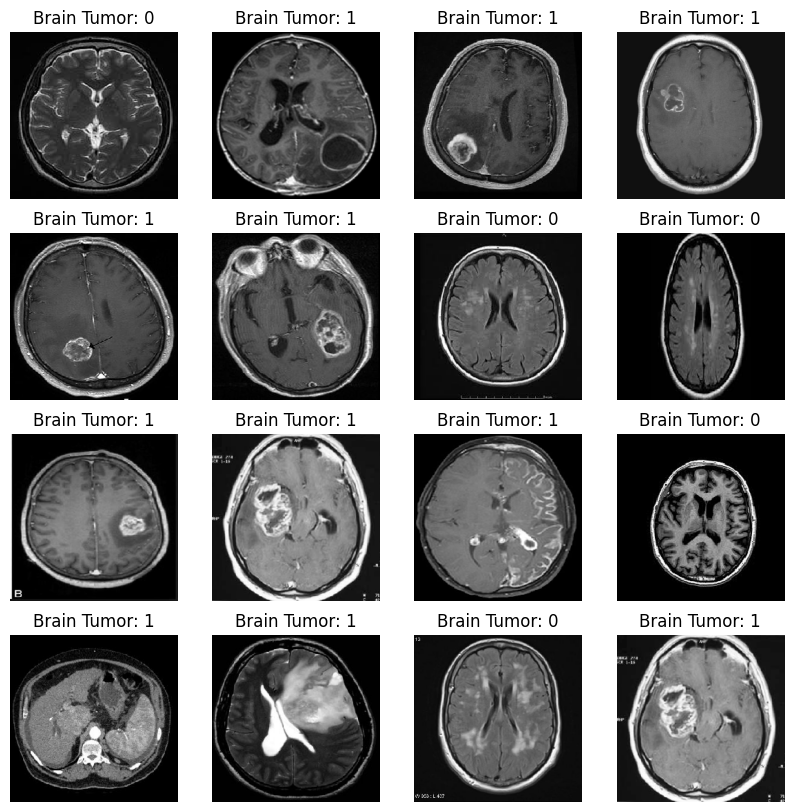

In [24]:
fig, ax = plt.subplots(4,4, figsize=(10,10))
for k in range(16):
    images, labels = train_ds.next()
    #print(images[0].shape)
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"Brain Tumor: {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()

**Helper Function - Plots Accuracy and Loss Curves**

In [25]:
def plots(history):
  sns.set_style("darkgrid") #Enabling grid of the graphs

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1,len(accuracy)+1)
  plt.figure(figsize=[12,6])

  plt.subplot(1, 2, 1) #Plotting Training vs Validation Accuracy
  plt.plot(epochs, accuracy, '-', label = 'Training Accuracy')
  plt.plot(epochs, val_accuracy, ':', label = 'Validation Accuracy')
  plt.title('Training Vs Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc = 'lower right')

  plt.subplot(1, 2, 2) #Plotting Training vs Validation Loss
  plt.plot(epochs, loss, '-', label = 'Training Loss')
  plt.plot(epochs, val_loss, ':', label = 'Validation Loss')
  plt.title('Training Vs Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc = 'upper right')

  plt.show()

In [55]:
def plot_confusion_matrix(model, data):
    predictions = model.predict(data)
    labels = np.where(predictions>0.5,1,0)
    cm = confusion_matrix(data.labels, labels)
    plt.figure(figsize=(8,8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tumor','No Tumor'])
    disp.plot()
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.xticks(rotation ='vertical')
    plt.show()

**ResNet50V2 - Deep Neural Network**

In [27]:
base_model = ResNet50V2(input_shape=(244,244,3), include_top=False)
base_model.trainable = False

model1 = Sequential([
    base_model, 
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model1.compile(optimizer=Adam(), 
               loss="binary_crossentropy", 
               metrics=['accuracy'])

model1.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint('resnet50v2_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history1 = model1.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

94668760/94668760 [==============================] - 11s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [35]:
model = load_model('resnet50v2_best.h5')
start_time = time.time()
model.evaluate(test_ds)
end_time = time.time()
print(f"Inference time: {(end_time-start_time)}")


4/4 [==============================] - 8s 1s/step - loss: 0.7320 - accuracy: 0.8039
Inference time: 8.20528531074524


In [96]:
ort.get_device()

'GPU'

In [94]:
output_path = "resnet50v2_best.onnx"
spec = [(tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name="input"))]

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save_model(model_proto, output_path)

providers = ['CPUExecutionProvider']
session = ort.InferenceSession(output_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

start_time = time.time()
onnx_pred = session.run([output_name], {input_name: test_ds})[0]
end_time = time.time()

accuracy = accuracy_score(np.argmax(onnx_pred, axis=1), test_ds.labels)
print(f"Inference time: {(end_time-start_time)}")
print(f"Accuracy {accuracy}")

AttributeError: 'FuncGraph' object has no attribute '_captures'

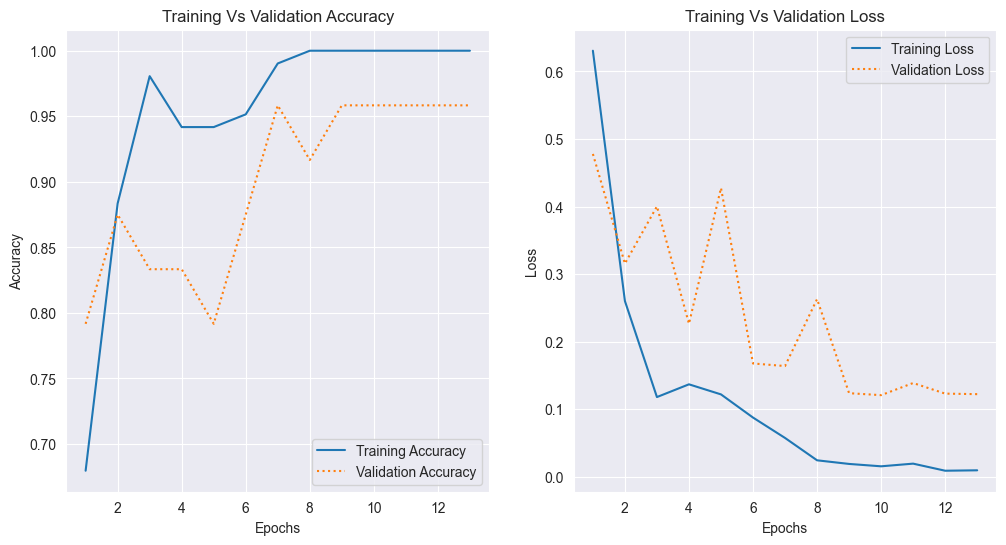

In [53]:
plots(history1)

4/4 [==============================] - 7s 1s/step


<Figure size 800x800 with 0 Axes>

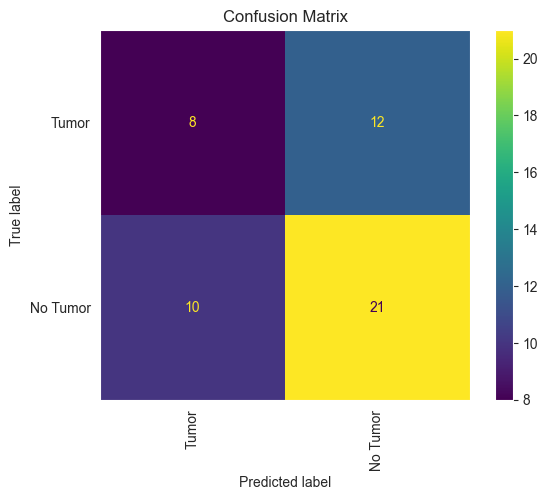

In [56]:
plot_confusion_matrix(model, test_ds)

**ResNet50V2 - Deep Neural Network with Augmented Data**

In [57]:
aug_train_ds = augmented_data(244, 244)
checkpoint = tf.keras.callbacks.ModelCheckpoint('resnet50v2aug_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=4, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history2 = model1.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Found 127 images belonging to 2 classes.


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.8898
Epoch 1: accuracy improved from -inf to 0.88976, saving model to resnet50v2aug_best.h5
8/8 [==============================] - 20s 2s/step - loss: 0.2556 - accuracy: 0.8898 - val_loss: 0.4934 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9134
Epoch 2: accuracy improved from 0.88976 to 0.91339, saving model to resnet50v2aug_best.h5
8/8 [==============================] - 21s 3s/step - loss: 0.1678 - accuracy: 0.9134 - val_loss: 0.1571 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9213
Epoch 3: accuracy improved from 0.91339 to 0.92126, saving model to resnet50v2aug_best.h5
8/8 [==============================] - 20s 3s/step - loss: 0.1644 - accuracy: 0.9213 - val_loss: 0.1250 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 4/30
8/8 [=====================

In [61]:
model = load_model('resnet50v2aug_best.h5')
start_time = time.time()
model.evaluate(test_ds)
end_time = time.time()
print(f"Inference time: {(end_time-start_time)}")

4/4 [==============================] - 7s 1s/step - loss: 0.9877 - accuracy: 0.7647
Inference time: 6.892294406890869


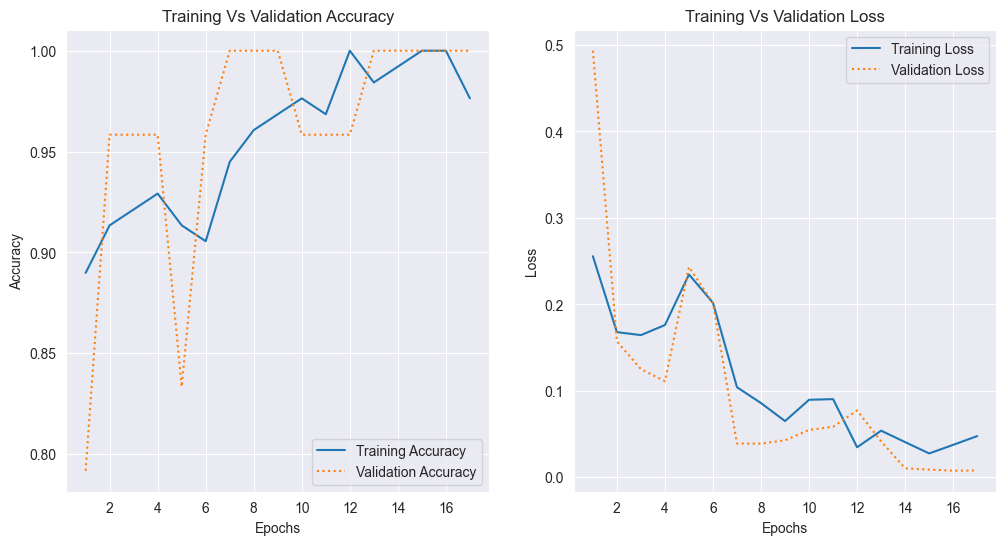

In [59]:
plots(history2)

4/4 [==============================] - 7s 1s/step


<Figure size 800x800 with 0 Axes>

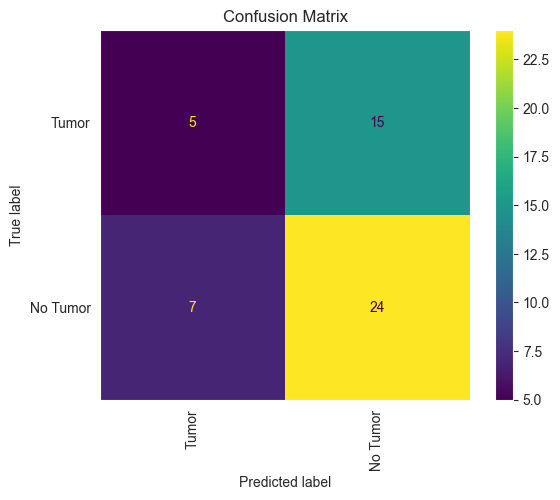

In [62]:
plot_confusion_matrix(model, test_ds)

**VGG19 - Deep Neural Network**

In [63]:
tf.keras.backend.clear_session()

#initializing new height and width for images
train_ds, val_ds, test_ds = image_gen(224, 224)

base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(1,activation='sigmoid'))

model2.compile(optimizer=Adam(), 
               loss="binary_crossentropy", 
               metrics=['accuracy'])
model2.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg19_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history3 = model2.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Found 103 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
80134624/80134624 [==============================] - 16s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
______________________

In [64]:
model = load_model('vgg19_best.h5')
start_time = time.time()
model.evaluate(test_ds)
end_time = time.time()
print(f"Inference time: {(end_time-start_time)}")

4/4 [==============================] - 15s 3s/step - loss: 0.6814 - accuracy: 0.7255
Inference time: 15.653375387191772


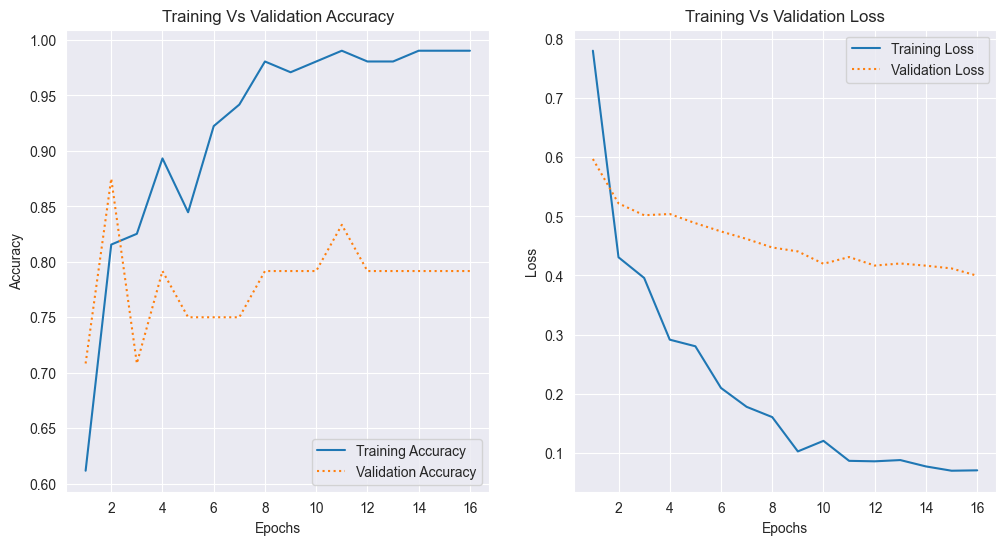

In [65]:
plots(history3)

4/4 [==============================] - 16s 4s/step


<Figure size 800x800 with 0 Axes>

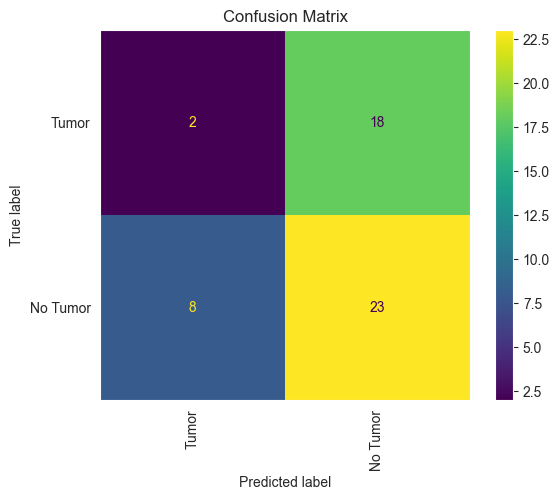

In [66]:
plot_confusion_matrix(model, test_ds)

**VGG19 - Deep Neural Network with Augmented Data**

In [67]:
aug_train_ds = augmented_data(224, 224)
checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg19_aug.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history4 = model2.fit(aug_train_ds, validation_data=val_ds, epochs=15, callbacks=callbacks_list)

Found 127 images belonging to 2 classes.


Epoch 1/15
8/8 [==============================] - ETA: 0s - loss: 0.4156 - accuracy: 0.7559
Epoch 1: accuracy improved from -inf to 0.75591, saving model to vgg19_aug.h5
8/8 [==============================] - 53s 7s/step - loss: 0.4156 - accuracy: 0.7559 - val_loss: 0.4477 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 2/15
8/8 [==============================] - ETA: 0s - loss: 0.4129 - accuracy: 0.8268
Epoch 2: accuracy improved from 0.75591 to 0.82677, saving model to vgg19_aug.h5
8/8 [==============================] - 49s 6s/step - loss: 0.4129 - accuracy: 0.8268 - val_loss: 0.3540 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 3/15
8/8 [==============================] - ETA: 0s - loss: 0.3772 - accuracy: 0.8346
Epoch 3: accuracy improved from 0.82677 to 0.83465, saving model to vgg19_aug.h5
8/8 [==============================] - 48s 6s/step - loss: 0.3772 - accuracy: 0.8346 - val_loss: 0.4325 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 4/15
8/8 [==============================] - ETA: 0s - loss

In [68]:
model = load_model('vgg19_aug.h5')
start_time = time.time()
model.evaluate(test_ds)
end_time = time.time()
print(f"Inference time: {(end_time-start_time)}")

4/4 [==============================] - 15s 3s/step - loss: 0.5199 - accuracy: 0.7647
Inference time: 15.424119710922241


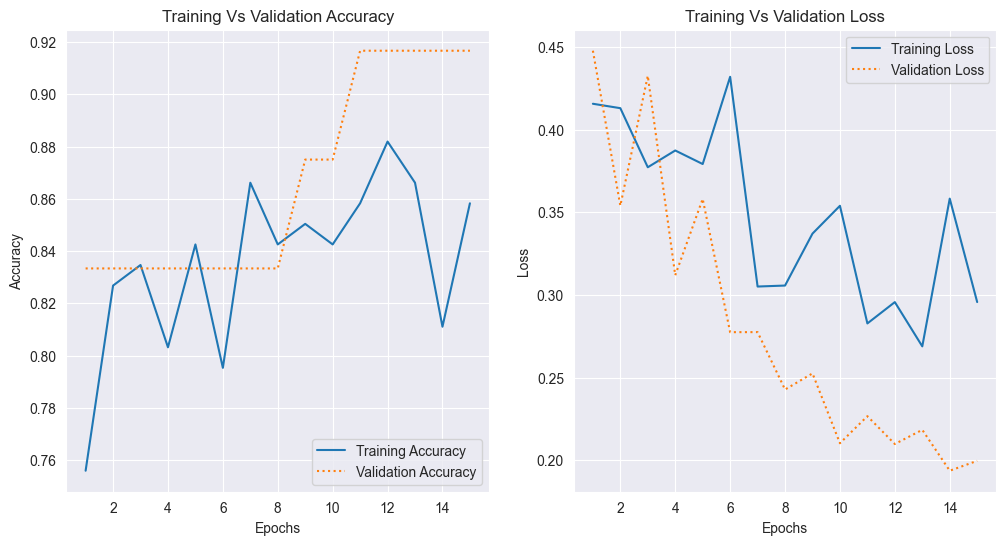

In [69]:
plots(history4)

4/4 [==============================] - 16s 3s/step


<Figure size 800x800 with 0 Axes>

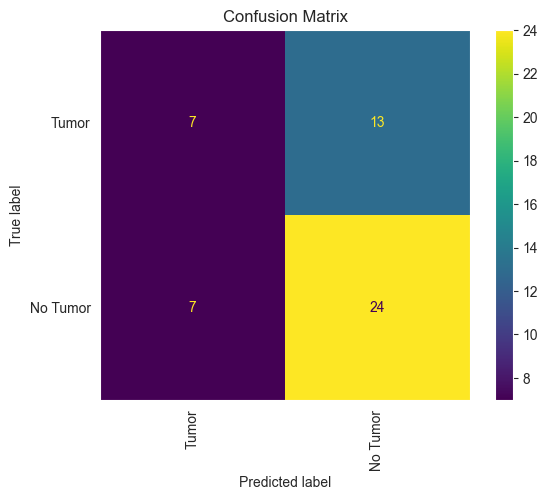

In [70]:
plot_confusion_matrix(model, test_ds)

**VGG16 - Deep Neural Network**

In [71]:
tf.keras.backend.clear_session()

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

model3 = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

model3.summary()

model3.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg16_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)

early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=3)

callbacks_list = [checkpoint,early]

history6 = model3.fit(train_ds, 
           validation_data=val_ds,
           epochs=15,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

58889256/58889256 [==============================] - 15s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/15
7/7 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.6311
Epoch 1: accuracy improved from -inf to 0.63107, saving model to vgg16_best.h5
7/7 [==============================] -

In [72]:
model = load_model('vgg16_best.h5')
start_time = time.time()
model.evaluate(test_ds)
end_time = time.time()
print(f"Inference time: {(end_time-start_time)}")

4/4 [==============================] - 12s 3s/step - loss: 0.5443 - accuracy: 0.7255
Inference time: 12.41807508468628


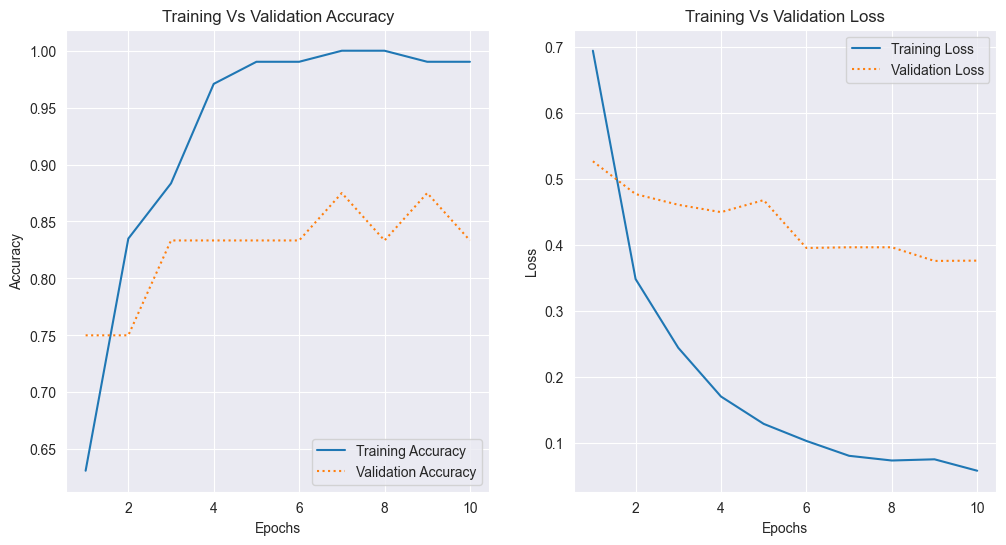

In [73]:
plots(history6)

4/4 [==============================] - 12s 3s/step


<Figure size 800x800 with 0 Axes>

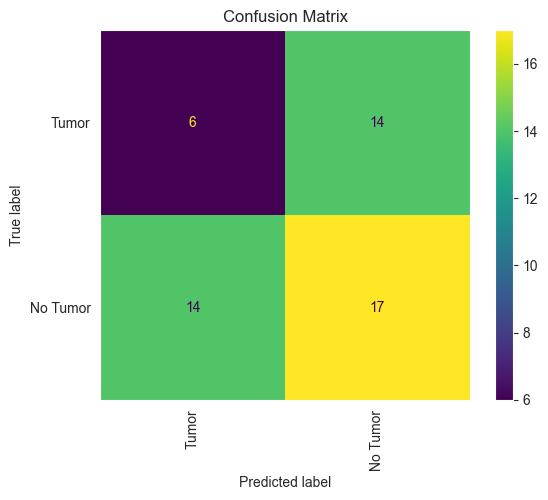

In [74]:
plot_confusion_matrix(model, test_ds)

**VGG16 - Deep Neural Network with Augmented Data**

In [75]:
aug_train_ds = augmented_data(224, 224)
checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg16_aug.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history7 = model3.fit(aug_train_ds, validation_data=val_ds, epochs=15, callbacks=callbacks_list)

Found 127 images belonging to 2 classes.


Epoch 1/15
8/8 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8583
Epoch 1: accuracy improved from -inf to 0.85827, saving model to vgg16_aug.h5
8/8 [==============================] - 37s 5s/step - loss: 0.3910 - accuracy: 0.8583 - val_loss: 0.4110 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/15
8/8 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.8976
Epoch 2: accuracy improved from 0.85827 to 0.89764, saving model to vgg16_aug.h5
8/8 [==============================] - 37s 5s/step - loss: 0.2991 - accuracy: 0.8976 - val_loss: 0.3591 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/15
8/8 [==============================] - ETA: 0s - loss: 0.3378 - accuracy: 0.8583
Epoch 3: accuracy did not improve from 0.89764
8/8 [==============================] - 37s 5s/step - loss: 0.3378 - accuracy: 0.8583 - val_loss: 0.2761 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 4/15
8/8 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.9134
Epoch 

In [76]:
model = load_model('vgg16_aug.h5')
start_time = time.time()
model.evaluate(test_ds)
end_time = time.time()
print(f"Inference time: {(end_time-start_time)}")

4/4 [==============================] - 12s 3s/step - loss: 0.4693 - accuracy: 0.8039
Inference time: 12.342668056488037


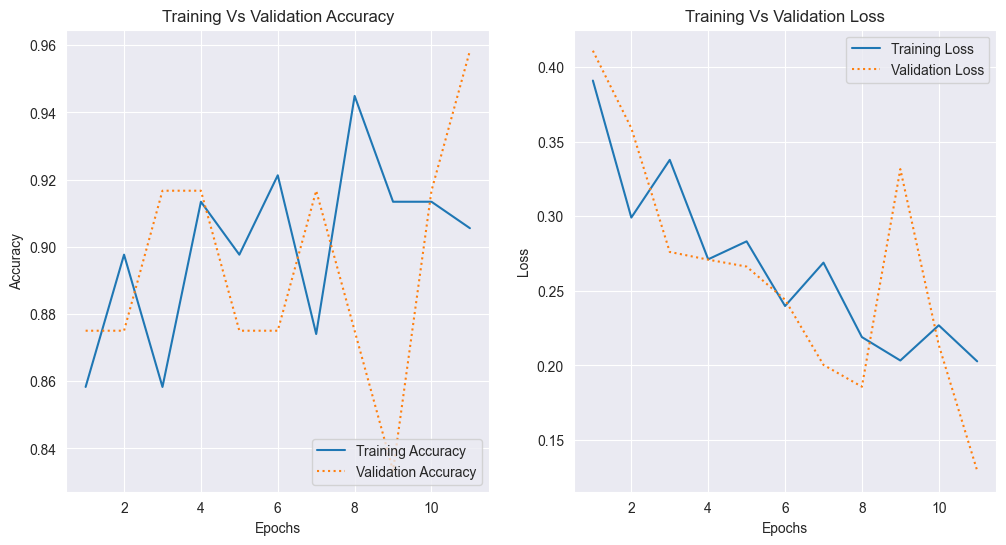

In [77]:
plots(history7)

4/4 [==============================] - 13s 3s/step


<Figure size 800x800 with 0 Axes>

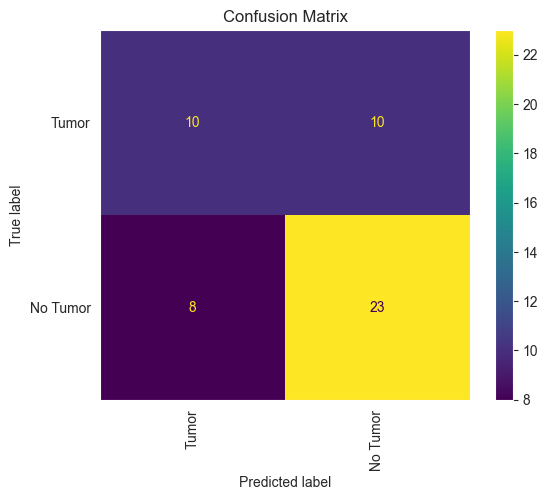

In [78]:
plot_confusion_matrix(model, test_ds)

**End of File**